In [338]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import time
import os
import joblib
import warnings

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, make_scorer, \
                            classification_report, average_precision_score, confusion_matrix
                
from sklearn.preprocessing import LabelEncoder, binarize
                
from sklearn.cross_validation import train_test_split, cross_val_predict

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV, \
                                    cross_validate

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data_csv/deal"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

cvm_kp_company_upd_ksb.csv
cvm_kp_company_upd_mmb.csv
cvm_kp_comp_dealdiff_upd_ksb.csv
cvm_kp_comp_dealdiff_upd_mmb.csv
cvm_kp_comp_share_prod_upd_ksb.csv
cvm_kp_comp_share_prod_upd_mmb.csv
cvm_kp_deal_upd_ksb.csv
cvm_kp_deal_upd_mmb.csv
cvm_kp_km_dealdiff_upd_ksb.csv
cvm_kp_km_dealdiff_upd_mmb.csv
cvm_kp_km_share_prod_upd.csv
cvm_kp_km_upd_ksb.csv
cvm_kp_km_upd_mmb.csv



In [339]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [340]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(7,9))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print('AUC: %.5f, Precision: %.5f, Recall: %.5f, F1: %.5f \n' % (roc_auc_score(y_test, y_pred_proba), \
                                    precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                                                                     f1_score(y_test, y_pred)))
    print('Average precision: %.5f \n' % average_precision_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred, digits=5))
    confusion_matrix_heatmap(y_test, y_pred)
    
def confusion_matrix_heatmap(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def eval_model_with_early_stopping(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train,
             eval_metric = 'auc',
             eval_set = [(X_train, y_train),(X_test, y_test)],
             early_stopping_rounds = 15, #сколько раундов не было улучшения на тесте
             verbose = 10)

    print('Test set')
    y_test_pred_model = model.predict(X_test)
    print(classification_report(y_test, y_test_pred_model, digits=5))
    auc = roc_auc_score(y_test, y_test_pred_model)
    print('AUC %.5f' % auc)
    confusion_matrix_heatmap(y_test, y_test_pred_model)

    return model, auc

In [341]:
def add_noise(series, noise_level):
    if series is not None:
        for col in series.columns:
            if series[col].dtypes != 'O':
                series[col]=series[col] * (1 + noise_level * np.random.randn(len(series)))
    return series

In [342]:
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=100, 
                  exp_norm=100,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    if tst_series is not None:
        assert len(trn_series) == len(target)
        assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg([('mean','mean'),
                                                                  ('count','count'),
                                                                  ('std', lambda x: np.std(x,ddof=0))])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / exp_norm))
    # Apply average function to all target data
    prior     = target.mean()
    prior_std = target.std()
    # The bigger the count the less full_avg is taken into account
    averages['_avg_mean'] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages['_avg_std']  = prior_std * (1 - smoothing) + averages["std"] * smoothing
    averages.drop(["mean", "count", "std"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name}),
        on=trn_series.name,
        how='left')[['_avg_mean','_avg_std']].rename(columns={'_avg_mean': trn_series.name+'_avg_mean',
                                                              '_avg_std' : trn_series.name+'_avg_std'})
    ft_trn_series[trn_series.name+'_avg_mean'].fillna(prior)
    ft_trn_series[trn_series.name+'_avg_std'].fillna(prior_std)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    
    
    if tst_series is not None:
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name}),
            on=tst_series.name,
            how='left')[['_avg_mean','_avg_std']].rename(columns={'_avg_mean': trn_series.name+'_avg_mean',
                                                                  '_avg_std' : trn_series.name+'_avg_std'})
        ft_tst_series[trn_series.name+'_avg_mean'].fillna(prior)
        ft_tst_series[trn_series.name+'_avg_std'].fillna(prior_std)
        # pd.merge does not keep the index so restore it
        ft_tst_series.index = tst_series.index
    else:
        ft_tst_series=None
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [343]:
def target_encode_df( trn_df=None, 
                      tst_df=None, 
                      target=None, 
                      cat_features_lst=None,
                      min_samples_leaf=100, 
                      exp_norm=100,
                      noise_level=0 ):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    
    if tst_df is not None:
        assert len(trn_df.columns) == len(tst_df.columns)
        assert len(list(set(trn_df.columns) - set(tst_df.columns))) == 0
    
    for col in cat_features_lst:
        
        trn_series=trn_df[col]
        if tst_df is not None:
            tst_series=tst_df[col]
        else:
            tst_series=None
            
        temp = pd.concat([trn_series, target], axis=1)
       
        # Compute target mean
        averages = temp.groupby(by=trn_series.name)[target.name].agg([('mean','mean'),
                                                                      ('count','count'),
                                                                      ('std', lambda x: np.std(x,ddof=0))])

            
        # Compute smoothing
        smoothing = 1. / (1. + np.exp(-(averages['count'] - min_samples_leaf) / exp_norm))
        # Apply average function to all target data
        prior     = target.mean()
        prior_std = target.std()    

        # The bigger the count the less full_avg is taken into account
        averages['_avg_mean'] = prior * (1 - smoothing) + averages['mean'] * smoothing
        averages['_avg_std']  = prior_std * (1 - smoothing) + averages['std'] * smoothing
        averages.drop(["mean", "count", "std"], axis=1, inplace=True)
        
        
        # Apply averages to trn and tst series
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name}),
            on=trn_series.name,
            how='left')[[trn_series.name,'_avg_mean','_avg_std']].rename(columns={
                                                                  '_avg_mean': trn_series.name+'_avg_mean',
                                                                  '_avg_std' : trn_series.name+'_avg_std'})
        ft_trn_series[trn_series.name+'_avg_mean'].fillna(prior)
        ft_trn_series[trn_series.name+'_avg_std'].fillna(prior_std)
        # pd.merge does not keep the index so restore it
        ft_trn_series.index = trn_series.index 
        
        if tst_series is not None:
            ft_tst_series = pd.merge(
                tst_series.to_frame(tst_series.name),
                averages.reset_index().rename(columns={'index': target.name}),
                on=tst_series.name,
                how='left')[[trn_series.name,'_avg_mean','_avg_std']].rename(columns={
                                                                      '_avg_mean': trn_series.name+'_avg_mean',
                                                                      '_avg_std' : trn_series.name+'_avg_std'})
            ft_tst_series[trn_series.name+'_avg_mean'].fillna(prior)
            ft_tst_series[trn_series.name+'_avg_std'].fillna(prior_std)
            # pd.merge does not keep the index so restore it
            ft_tst_series.index = tst_series.index
        else:
            ft_tst_series=None
        
 
        add_noise(ft_trn_series, noise_level)
    
        if ft_tst_series is not None:
            add_noise(ft_tst_series, noise_level)
    
        trn_df=pd.merge(
                        trn_df,
                        ft_trn_series,
                        on=trn_series.name,
                        how='left')
        
        #trn_df.drop([col], axis = 1, inplace=True)
        
        if tst_df is not None:
            tst_df.drop(col, axis = 1, inplace=True)
            tst_df=pd.merge(
                            tst_df,
                            ft_tst_series,
                            on=tst_series.name,
                            how='left')
            #tst_df.drop([col], axis = 1, inplace=True)

    
    return trn_df, tst_df

In [344]:
def target_encode_df_join(        trn_df=None, 
                                  tst_df=None, 
                                  target=None, 
                                  cat_features_lst=None,
                                  min_samples_leaf=100, 
                                  exp_norm=100,
                                  noise_level=0 ):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    
    if tst_df is not None:
        assert len(trn_df.columns) == len(tst_df.columns)
        assert len(list(set(trn_df.columns) - set(tst_df.columns))) == 0
    
    for col in cat_features_lst:
        
        trn_series=trn_df[col]
        if tst_df is not None:
            tst_series=tst_df[col]
        else:
            tst_series=None
            
        temp = pd.concat([trn_series, target], axis=1)
       
        # Compute target mean
        averages = temp.groupby(by=trn_series.name)[target.name].agg([('mean','mean'),
                                                                      ('count','count'),
                                                                      ('std', lambda x: np.std(x,ddof=0))])

            
        # Compute smoothing
        smoothing = 1. / (1. + np.exp(-(averages['count'] - min_samples_leaf) / exp_norm))
        # Apply average function to all target data
        prior     = target.mean()
        prior_std = target.std()    

        # The bigger the count the less full_avg is taken into account
        averages['_avg_mean'] = prior * (1 - smoothing) + averages['mean'] * smoothing
        averages['_avg_std']  = prior_std * (1 - smoothing) + averages['std'] * smoothing
        averages.drop(["mean", "count", "std"], axis=1, inplace=True)
        
        
        # Apply averages to trn and tst series
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name}),
            on=trn_series.name,
            how='left')[['_avg_mean','_avg_std']].rename(columns={
                                                                  '_avg_mean': trn_series.name+'_avg_mean',
                                                                  '_avg_std' : trn_series.name+'_avg_std'})
        ft_trn_series[trn_series.name+'_avg_mean'].fillna(prior)
        ft_trn_series[trn_series.name+'_avg_std'].fillna(prior_std)
        # pd.merge does not keep the index so restore it
        ft_trn_series.index = trn_series.index 
        
        if tst_series is not None:
            ft_tst_series = pd.merge(
                tst_series.to_frame(tst_series.name),
                averages.reset_index().rename(columns={'index': target.name}),
                on=tst_series.name,
                how='left')[['_avg_mean','_avg_std']].rename(columns={
                                                                      '_avg_mean': trn_series.name+'_avg_mean',
                                                                      '_avg_std' : trn_series.name+'_avg_std'})
            ft_tst_series[trn_series.name+'_avg_mean'].fillna(prior)
            ft_tst_series[trn_series.name+'_avg_std'].fillna(prior_std)
            # pd.merge does not keep the index so restore it
            ft_tst_series.index = tst_series.index
        else:
            ft_tst_series=None
        
 
        add_noise(ft_trn_series, noise_level)
        
        trn_df=trn_df.join(ft_trn_series)
        
        if ft_tst_series is not None:
            add_noise(ft_tst_series, noise_level)
            tst_df=tst_df.join(ft_tst_series)
        
        #trn_df.drop([col], axis = 1, inplace=True)
        
        #if tst_df is not None:
        #    tst_df.drop([col], axis = 1, inplace=True)

    
    return trn_df, tst_df

In [345]:
df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl')

In [346]:
top_corr_features = pd.read_pickle('pkl_store/top_corr_features_le_all.pkl')


In [347]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), 
                     df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Sum of sold', 'Count']
balance['balance'] = balance['Sum of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
balance

,Sum of sold,Count,balance
product_group,,,
РОЗНИЧНЫЕ ПРОДУКТЫ,2,2,1.000000
ВЕКСЕЛЯ,98,98,1.000000
АРЕНДА СЕЙФОВ,1,1,1.000000
ИНФОРМАЦИОННЫЕ УСЛУГИ,17565,18384,0.955450
РКО,66961,70256,0.953100
ИНКАССАЦИЯ,26211,27795,0.943011
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,43786,47067,0.930291
ПАКЕТЫ УСЛУГ,34425,37732,0.912356
КОНВЕРСИОННЫЕ ОПЕРАЦИИ,233,256,0.910156


In [348]:
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)

In [349]:
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [350]:
unique_counts = pd.DataFrame()
for col in df.columns:
    unique_counts = unique_counts.append([[col, len(df[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']
unique_counts.head()

,colname,unique_counts
0,is_sold,2
0,tb,14
0,gosb,90
0,product,132
0,product_group,28


In [351]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values
non_unique_columns

array([], dtype=object)

In [352]:
target_column = 'is_sold'
#drop_columns = ['ckp']
#X, y = df.drop(target_column, axis = 1).drop(drop_columns, 1), df[target_column]
X, y = df.drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df[target_column]

In [ ]:
X=X[top_corr_features]
X.head()

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.35, random_state=42)

In [355]:
len(list(set(X_train.columns) - set(X_test.columns)))

0

In [ ]:
X_train.head()

In [357]:
s=X_train['product']
type(s)

pandas.core.series.Series

In [358]:
conc=pd.concat([X_train['product_group'], y_train], axis=1)
averages = conc.groupby(by='product_group')['is_sold'].agg(["mean", "count"])
averages

,mean,count
product_group,,
CASH MANAGEMENT,0.148148,27
БАНКОВСКАЯ ГАРАНТИЯ,0.638658,2892
БИЗНЕС-КАРТА,0.679676,34821
ВАЛЮТНЫЙ КОНТРОЛЬ,0.828877,187
ВНЕШНИЙ МАЛЫЙ СМАРТ,0.470588,17
ВНЕШНИЙ МИКРО СМАРТ,0.523810,42
ДЕЛОВАЯ СРЕДА,0.847222,216
ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ,0.837209,43
ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,0.324566,5361


In [359]:
averages = df.groupby(by='product_group')['is_sold'].transform(np.sum)
averages.index=df['product_group'].values
averages

КРЕДИТОВАНИЕ                    19180
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ    43786
ПАКЕТЫ УСЛУГ                    34425
ПАКЕТЫ УСЛУГ                    34425
РКО                             66961
ЭКВАЙРИНГ                       12439
ЭКВАЙРИНГ                       12439
ПАКЕТЫ УСЛУГ                    34425
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ    43786
КРЕДИТОВАНИЕ                    19180
РКО                             66961
КРЕДИТОВАНИЕ                    19180
КРЕДИТОВАНИЕ                    19180
КРЕДИТОВАНИЕ                    19180
ИНФОРМАЦИОННЫЕ УСЛУГИ           17565
ПАКЕТЫ УСЛУГ                    34425
КРЕДИТОВАНИЕ                    19180
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ    43786
ИНФОРМАЦИОННЫЕ УСЛУГИ           17565
РКО                             66961
БИЗНЕС-КАРТА                    36442
ПАКЕТЫ УСЛУГ                    34425
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ    43786
КРЕДИТОВАНИЕ                    19180
ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ       2636
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ    43786
КРЕДИТОВАНИЕ

## Target Encoding

In [360]:
cat_features_lst=list(X_train.dtypes[X_train.dtypes == 'O'].index)
cat_features_lst

['product', 'product_group', 'gosb', 'tb', 'priority_client', 'segment_client']

In [361]:
#trn_db=pd.DataFrame(X.iloc[:20,:])
trn, tst = target_encode_df_join(   
                                     X_train, 
                                     X_test, 
                                     target=y_train, 
                                     cat_features_lst=cat_features_lst,
                                     min_samples_leaf=100,
                                     exp_norm=100,
                                     noise_level=0.01
                                   )


In [362]:
trn.shape, tst.shape

((270259, 170), (145525, 170))

In [ ]:
trn.head()

## Label Encoding

In [364]:
from label_encoder import SoftLabelEncoder

In [365]:
# label_encoders = {}
# for col in trn.dtypes[trn.dtypes == 'O'].index:
#     le = SoftLabelEncoder()
#     trn[col] = le.fit_transform(trn[col].fillna('NaN'))
#     label_encoders[col] = le

In [366]:
le=joblib.load('pkl_store/label_encoders_trn.pkl')
le

{'gosb': <label_encoder.SoftLabelEncoder at 0x7f84c4c612e8>,
 'priority_client': <label_encoder.SoftLabelEncoder at 0x7f84c4c61fd0>,
 'product': <label_encoder.SoftLabelEncoder at 0x7f84c4c61860>,
 'product_group': <label_encoder.SoftLabelEncoder at 0x7f84c4c613c8>,
 'segment_client': <label_encoder.SoftLabelEncoder at 0x7f84c4c61978>,
 'tb': <label_encoder.SoftLabelEncoder at 0x7f84c4c61c18>}

In [367]:
for col in trn.dtypes[trn.dtypes == 'O'].index:
    trn[col] = le[col].transform(trn[col].fillna('NaN'))
    
for col in tst.dtypes[tst.dtypes == 'O'].index:
    tst[col] = le[col].transform(tst[col].fillna('NaN'))

In [ ]:
tst.head()

## Polynomial Features

In [369]:
from sklearn.preprocessing import PolynomialFeatures

In [370]:
pf = PolynomialFeatures(3,interaction_only=True)

In [371]:
feature_imp=joblib.load('pkl_store/rfecv_dict_imp_le_all.pkl')

In [372]:
impotant_columns = [col[0] for col in sorted(zip(list(feature_imp.keys()), list(feature_imp.values())), 
                                             key=lambda x: x[1], reverse=True)[:10]]
impotant_columns

['product',
 'product_group',
 'days_cr_q_end',
 'gosb',
 'tb',
 'days_between',
 'priority_client',
 'days_between_km_dealdiff',
 'sum_sold_total_cumulate_km_shift_3',
 'sum_sold_cumulate']

In [373]:
cattopoly=[ 'product_avg_mean',
            'product_avg_std',
            'product_group_avg_mean',
            'product_group_avg_std',
            'gosb_avg_mean',
            'gosb_avg_std',
            'tb_avg_mean',
            'tb_avg_std',
            'priority_client_avg_mean',
            'priority_client_avg_std',
            'days_between_km_dealdiff',
            'sum_sold_total_cumulate_km_shift_3'
]

## fit/transform train dataset

In [374]:
pf_df=pd.DataFrame(pf.fit_transform(trn[cattopoly]), columns=pf.get_feature_names(cattopoly), \
                           index=trn.index)

In [375]:
pf_df.drop(["1"], axis=1, inplace=True)
pf_df.drop(cattopoly, axis=1, inplace=True)

In [376]:
pf_df.head()

,product_avg_mean product_avg_std,product_avg_mean product_group_avg_mean,product_avg_mean product_group_avg_std,product_avg_mean gosb_avg_mean,product_avg_mean gosb_avg_std,product_avg_mean tb_avg_mean,product_avg_mean tb_avg_std,product_avg_mean priority_client_avg_mean,product_avg_mean priority_client_avg_std,product_avg_mean days_between_km_dealdiff,...,tb_avg_std priority_client_avg_mean priority_client_avg_std,tb_avg_std priority_client_avg_mean days_between_km_dealdiff,tb_avg_std priority_client_avg_mean sum_sold_total_cumulate_km_shift_3,tb_avg_std priority_client_avg_std days_between_km_dealdiff,tb_avg_std priority_client_avg_std sum_sold_total_cumulate_km_shift_3,tb_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean priority_client_avg_std days_between_km_dealdiff,priority_client_avg_mean priority_client_avg_std sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3
0,0.219037,0.147075,0.205889,0.348345,0.181227,0.325881,0.191664,0.290291,0.211142,10.600197,...,0.136346,6.845124,0.285213,4.978767,0.207449,10.414775,7.540751,0.314198,15.774030,11.473164
1,0.238162,0.855655,0.236281,0.745275,0.362300,0.695474,0.401218,0.604447,0.432821,6.447517,...,0.134327,2.001001,3.430288,1.432840,2.456298,36.590205,2.158619,3.700490,55.124299,39.472395
2,0.311556,0.755485,0.239197,0.463464,0.416681,0.604229,0.369731,0.541519,0.390754,NaN,...,0.138248,NaN,4.096986,NaN,2.956339,NaN,NaN,4.329941,NaN,NaN
3,0.209807,0.862087,0.269879,0.737922,0.402562,0.666368,0.431367,0.678383,0.420440,11.306808,...,0.147079,3.955362,3.955362,2.451405,2.451405,65.925127,3.855166,3.855166,103.676182,64.255127
4,0.222290,0.892727,0.199682,0.701922,0.411364,0.724699,0.391962,0.672649,0.426971,NaN,...,0.134599,NaN,20.790735,NaN,13.197155,NaN,NaN,22.647756,NaN,NaN


In [377]:
trn.shape

(270259, 170)

In [378]:
trn=trn.join(pf_df)

In [379]:
trn.shape, y.shape

((270259, 456), (415784,))

In [380]:
trn.head()

,product,product_group,days_cr_q_end,gosb,tb,days_between,priority_client,days_between_km_dealdiff,sum_sold_total_cumulate_km_shift_3,sum_sold_cumulate_agg_km_shift_1,...,tb_avg_std priority_client_avg_mean priority_client_avg_std,tb_avg_std priority_client_avg_mean days_between_km_dealdiff,tb_avg_std priority_client_avg_mean sum_sold_total_cumulate_km_shift_3,tb_avg_std priority_client_avg_std days_between_km_dealdiff,tb_avg_std priority_client_avg_std sum_sold_total_cumulate_km_shift_3,tb_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean priority_client_avg_std days_between_km_dealdiff,priority_client_avg_mean priority_client_avg_std sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3
0,2,17,52,75,4,NaN,7,24.0,1.0,2.0,...,0.136346,6.845124,0.285213,4.978767,0.207449,10.414775,7.540751,0.314198,15.774030,11.473164
1,43,21,25,73,8,29.0,7,7.0,12.0,22.0,...,0.134327,2.001001,3.430288,1.432840,2.456298,36.590205,2.158619,3.700490,55.124299,39.472395
2,87,18,23,43,11,NaN,7,NaN,14.0,0.0,...,0.138248,NaN,4.096986,NaN,2.956339,NaN,NaN,4.329941,NaN,NaN
3,81,18,19,52,6,NaN,8,12.0,12.0,3.0,...,0.147079,3.955362,3.955362,2.451405,2.451405,65.925127,3.855166,3.855166,103.676182,64.255127
4,74,22,75,40,10,NaN,8,NaN,70.0,31.0,...,0.134599,NaN,20.790735,NaN,13.197155,NaN,NaN,22.647756,NaN,NaN


## transform test dataset

In [381]:
pf_df=pd.DataFrame(pf.transform(tst[cattopoly]), columns=pf.get_feature_names(cattopoly), \
                           index=tst.index)

In [382]:
pf_df.drop(["1"], axis=1, inplace=True)
pf_df.drop(cattopoly, axis=1, inplace=True)

In [383]:
tst=tst.join(pf_df)

In [384]:
trn.shape, tst.shape, y_test.shape, y_train.shape

((270259, 456), (145525, 456), (145525,), (270259,))

In [397]:
trn.iloc[[1,2,3]]

,product,product_group,days_cr_q_end,gosb,tb,days_between,priority_client,days_between_km_dealdiff,sum_sold_total_cumulate_km_shift_3,sum_sold_cumulate_agg_km_shift_1,...,tb_avg_std priority_client_avg_mean priority_client_avg_std,tb_avg_std priority_client_avg_mean days_between_km_dealdiff,tb_avg_std priority_client_avg_mean sum_sold_total_cumulate_km_shift_3,tb_avg_std priority_client_avg_std days_between_km_dealdiff,tb_avg_std priority_client_avg_std sum_sold_total_cumulate_km_shift_3,tb_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean priority_client_avg_std days_between_km_dealdiff,priority_client_avg_mean priority_client_avg_std sum_sold_total_cumulate_km_shift_3,priority_client_avg_mean days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3,priority_client_avg_std days_between_km_dealdiff sum_sold_total_cumulate_km_shift_3
1,43,21,25,73,8,29.0,7,7.0,12.0,22.0,...,0.134327,2.001001,3.430288,1.432840,2.456298,36.590205,2.158619,3.700490,55.124299,39.472395
2,87,18,23,43,11,NaN,7,NaN,14.0,0.0,...,0.138248,NaN,4.096986,NaN,2.956339,NaN,NaN,4.329941,NaN,NaN
3,81,18,19,52,6,NaN,8,12.0,12.0,3.0,...,0.147079,3.955362,3.955362,2.451405,2.451405,65.925127,3.855166,3.855166,103.676182,64.255127


## fit model

In [385]:
le=joblib.load(get_path('pkl_store', 'label_encoders_trn.pkl'))
cat_features=list(set(le.keys()))
cat_features

['priority_client', 'tb', 'segment_client', 'gosb', 'product_group', 'product']

In [1]:
from lightgbm import LGBMClassifier, plot_metric, plot_importance

In [2]:
gbm = LGBMClassifier(n_estimators=15000, num_leaves=150, max_bin=100, bagging_fraction=0.8, bagging_freq=10, n_jobs=60, 
                     feature_fraction=0.5, lambda_l1=0, lambda_l2=1, min_child_weight=1e-05,
                     min_data_in_leaf=100, random_state=42)

In [388]:
%%time
gbm.fit(trn, y_train, eval_set=[(trn, y_train), (tst, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=True)

/opt/cloudera/parcels/PYENV.ZNO41714840/lib/python3.5/site-packages/lightgbm/basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['gosb', 'priority_client', 'product', 'product_group', 'segment_client', 'tb']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's auc: 0.855636	valid_1's auc: 0.852472
Training until validation scores don't improve for 15 rounds.
[2]	training's auc: 0.860361	valid_1's auc: 0.855958
[3]	training's auc: 0.862474	valid_1's auc: 0.858171
[4]	training's auc: 0.863335	valid_1's auc: 0.858757
[5]	training's auc: 0.864808	valid_1's auc: 0.85973
[6]	training's auc: 0.866034	valid_1's auc: 0.860639
[7]	training's auc: 0.867225	valid_1's auc: 0.861432
[8]	training's auc: 0.867774	valid_1's auc: 0.861888
[9]	training's auc: 0.868376	valid_1's auc: 0.862391
[10]	training's auc: 0.869127	valid_1's auc: 0.862605
[11]	training's auc: 0.869873	valid_1's auc: 0.862978
[12]	training's auc: 0.87139	valid_1's auc: 0.864236
[13]	training's auc: 0.872133	valid_1's auc: 0.864605
[14]	training's auc: 0.873226	valid_1's auc: 0.865381
[15]	training's auc: 0.873749	valid_1's auc: 0.865656
[16]	training's auc: 0.874571	valid_1's auc: 0.866276
[17]	training's auc: 0.875105	valid_1's auc: 0.866615
[18]	training's auc: 0.87553	va

[152]	training's auc: 0.934022	valid_1's auc: 0.88112
[153]	training's auc: 0.934275	valid_1's auc: 0.881133
[154]	training's auc: 0.934537	valid_1's auc: 0.881135
[155]	training's auc: 0.934818	valid_1's auc: 0.881162
[156]	training's auc: 0.935068	valid_1's auc: 0.881131
[157]	training's auc: 0.935328	valid_1's auc: 0.881158
[158]	training's auc: 0.93557	valid_1's auc: 0.881167
[159]	training's auc: 0.935837	valid_1's auc: 0.881208
[160]	training's auc: 0.936079	valid_1's auc: 0.88122
[161]	training's auc: 0.936358	valid_1's auc: 0.881256
[162]	training's auc: 0.936577	valid_1's auc: 0.881301
[163]	training's auc: 0.936826	valid_1's auc: 0.88129
[164]	training's auc: 0.937124	valid_1's auc: 0.881321
[165]	training's auc: 0.937409	valid_1's auc: 0.881343
[166]	training's auc: 0.937642	valid_1's auc: 0.881335
[167]	training's auc: 0.937878	valid_1's auc: 0.881366
[168]	training's auc: 0.938129	valid_1's auc: 0.881402
[169]	training's auc: 0.938353	valid_1's auc: 0.88141
[170]	training'

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.5, lambda_l1=0,
        lambda_l2=1, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=1e-05, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=15000, n_jobs=60, num_leaves=150,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.88160, Precision: 0.85994, Recall: 0.91436, F1: 0.88631 

Average precision: 0.95424 

             precision    recall  f1-score   support

          0    0.70101   0.57416   0.63128     37707
          1    0.85994   0.91436   0.88631    107818

avg / total    0.81876   0.82621   0.82023    145525



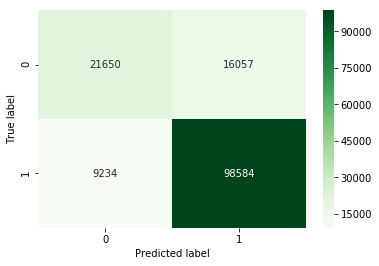

In [389]:
predict(gbm, tst, y_test)

## XGboost

In [390]:
params = {
     'base_score': 0.5,
     'booster': 'gbtree',
     'colsample_bylevel': 1,
     'colsample_bytree': 0.6,
     'gamma': 5,
     'learning_rate': 0.1,
     'max_delta_step': 0,
     'max_depth': 10,
     'min_child_weight': 10,
     'missing': None,
     'n_estimators': 15000,
     'n_jobs': 60,
     'nthread': None,
     'objective': 'binary:logistic',
     'random_state': 0,
     'reg_alpha': 0,
     'reg_lambda': 1,
     'scale_pos_weight': 1,
     'seed': 42,
     'silent': True,
     'subsample': 1.0
}
xgb = XGBClassifier(**params)

In [391]:
%%time
xgb.fit(trn, y_train,
             eval_metric = 'auc',
             eval_set = [(trn, y_train),(tst, y_test)],
             early_stopping_rounds = 15,
             verbose = 10)

[0]	validation_0-auc:0.863479	validation_1-auc:0.851768
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[10]	validation_0-auc:0.884959	validation_1-auc:0.866845
[20]	validation_0-auc:0.892606	validation_1-auc:0.869564
[30]	validation_0-auc:0.899571	validation_1-auc:0.871805
[40]	validation_0-auc:0.904952	validation_1-auc:0.873094
[50]	validation_0-auc:0.911241	validation_1-auc:0.874729
[60]	validation_0-auc:0.915194	validation_1-auc:0.875532
[70]	validation_0-auc:0.91766	validation_1-auc:0.876027
[80]	validation_0-auc:0.919381	validation_1-auc:0.876323
[90]	validation_0-auc:0.921279	validation_1-auc:0.876577
[100]	validation_0-auc:0.92284	validation_1-auc:0.876902
[110]	validation_0-auc:0.924074	validation_1-auc:0.87703
[120]	validation_0-auc:0.925938	validation_1-auc:0.87721
[130]	validation_0-auc:0.927688	validation_1-auc:0.877296
[140]	validation_0-auc:0.929983	validation_1-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=15000,
       n_jobs=60, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1.0)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.87851, Precision: 0.85742, Recall: 0.91363, F1: 0.88464 

Average precision: 0.95302 

             precision    recall  f1-score   support

          0    0.69607   0.56560   0.62409     37707
          1    0.85742   0.91363   0.88464    107818

avg / total    0.81562   0.82345   0.81713    145525



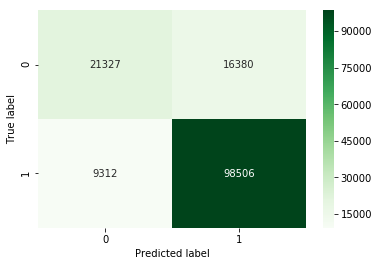

In [392]:
predict(xgb, tst, y_test)

In [393]:
# for col in X_train.dtypes[X_train.dtypes == 'O'].index:
#     trn, _ = target_encode(  X[col], 
#                              None, 
#                              target=y, 
#                              min_samples_leaf=100,
#                              exp_norm=100,
#                              noise_level=0.01)
    
#     trn_p, tst_p = target_encode(X_train[col], 
#                                  X_test[col], 
#                                  target=y_train, 
#                                  min_samples_leaf=100,
#                                  exp_norm=100,
#                                  noise_level=0.01)
#     conc=pd.concat([trn,trn_p],axis=1,names=['_full', '_part',])
#     print(conc.head())
#     print('\n')
#    # label_encoders[col] = le